In [43]:
"""
    Copyright (C) 2022 Francesca Meneghello
    contact: meneghello@dei.unipd.it
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

'\n    Copyright (C) 2022 Francesca Meneghello\n    contact: meneghello@dei.unipd.it\n    This program is free software: you can redistribute it and/or modify\n    it under the terms of the GNU General Public License as published by\n    the Free Software Foundation, either version 3 of the License, or\n    (at your option) any later version.\n    This program is distributed in the hope that it will be useful,\n    but WITHOUT ANY WARRANTY; without even the implied warranty of\n    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\n    GNU General Public License for more details.\n    You should have received a copy of the GNU General Public License\n    along with this program.  If not, see <https://www.gnu.org/licenses/>.\n'

In [73]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

from utilities import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, CrossEntropyLoss
from torch.optim import SGD, Adam
from tqdm import tqdm

In [74]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training
feature_length_init = 100 #Length along the feature dimension (height)
sample_length_init = 340 #Length along the time dimension (width)
channels_init = 1 #Number of channels
batch_size_init = 32 #Number of samples in a batch
num_tot_init = 4 #Number of antenna * number of spatial streams
name_base_init = 'single_ant' #Name base for the files
activities_init = 'E,L,W,R,J' #Activities to be considered
bandwidth_init = 80 #Bandwidth in [MHz] to select the subcarriers, can be 20, 40, 80 (default 80)
sub_band_init = 1 #Sub_band idx in [1, 2, 3, 4] for 20 MHz, [1, 2] for 40 MHz (default 1)

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#### Create datasets for training, validation and test
Generate the datasets using the ``create dataset single`` function which returns a DataLoader object

In [76]:
bandwidth = bandwidth_init
sub_band = sub_band_init

csi_act = activities_init
activities = []
for lab_act in csi_act.split(','):
    activities.append(lab_act)
activities = np.asarray(activities)

name_base = name_base_init
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_train.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_train.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_train.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_val.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_val.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_val.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_train_test.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_train_test.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_train_test.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_test.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_test.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_test.index')

subdirs_training = subdirs_init  # string
labels_train = []
all_files_train = []
labels_val = []
all_files_val = []
labels_test = []
all_files_test = []
sample_length = sample_length_init
feature_length = feature_length_init
channels = channels_init
num_antennas = num_tot_init
input_shape = (num_antennas, sample_length, feature_length, channels)
input_network = (sample_length, feature_length, channels)
batch_size = batch_size_init
output_shape = activities.shape[0]
labels_considered = np.arange(output_shape)
activities = activities[labels_considered]

suffix = '.txt'

for sdir in subdirs_training.split(','):
    exp_save_dir = dir_init + sdir + '/'
    
    dir_train = dir_init + sdir + '/train_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_train_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_train.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_train_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_train.extend(pickle.load(fp))

    dir_val = dir_init + sdir + '/val_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_val_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_val.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_val_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_val.extend(pickle.load(fp))

    dir_test = dir_init + sdir + '/test_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_test_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_test.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_test_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_test.extend(pickle.load(fp))


file_train_selected = [all_files_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                        labels_considered]
labels_train_selected = [labels_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                            labels_considered]

file_train_selected_expanded, labels_train_selected_expanded, stream_ant_train = \
    expand_antennas(file_train_selected, labels_train_selected, num_antennas)

# create the batches
name_cache = name_base + '_' + str(csi_act) + '_cache_train'
dataset_csi_train = create_dataset_single(file_train_selected_expanded, labels_train_selected_expanded,
                                            stream_ant_train, input_network, batch_size,
                                            shuffle=True, cache_file=name_cache)

file_val_selected = [all_files_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]
labels_val_selected = [labels_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]

file_val_selected_expanded, labels_val_selected_expanded, stream_ant_val = \
    expand_antennas(file_val_selected, labels_val_selected, num_antennas)

name_cache_val = name_base + '_' + str(csi_act) + '_cache_val'
dataset_csi_val = create_dataset_single(file_val_selected_expanded, labels_val_selected_expanded,
                                        stream_ant_val, input_network, batch_size,
                                        shuffle=False, cache_file=name_cache_val)

file_test_selected = [all_files_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]
labels_test_selected = [labels_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]

file_test_selected_expanded, labels_test_selected_expanded, stream_ant_test = \
    expand_antennas(file_test_selected, labels_test_selected, num_antennas)

name_cache_test = name_base + '_' + str(csi_act) + '_cache_test'
dataset_csi_test = create_dataset_single(file_test_selected_expanded, labels_test_selected_expanded,
                                            stream_ant_test, input_network, batch_size,
                                            shuffle=False, cache_file=name_cache_test)

In [77]:
226*32

7232

#### Define the model

In [78]:
from IPython.display import Image

# Display the image
Image(filename='../baseline_model.png', width=700, height=350)

FileNotFoundError: [Errno 2] No such file or directory: '../baseline_model.png'

``Conv2d_bn`` helper module

In [79]:
'''
class Conv2d_bn(Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding)
        self.relu = nn.ReLU()

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        return self.relu(x)
'''

'\nclass Conv2d_bn(Module):\n    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):\n        super().__init__()\n        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding)\n        self.relu = nn.ReLU()\n\n    def _init_weights(self, module):\n        if isinstance(module, torch.nn.Conv2d):\n            torch.nn.init.xavier_uniform_(module.weight)\n            if module.bias is not None:\n                module.bias.data.zero_()\n\n    def forward(self, x):\n        x = self.conv(x)\n        return self.relu(x)\n'

In [80]:
"""class Conv2d_bn(nn.Module):
    def init(self, in_filters, out_filters, kernel_size, strides=(1, 1), padding='same'):
        super(Conv2d_bn, self).init()
        
        # Calcola il padding asimmetrico necessario per 'same' padding
        if padding == 'same':
            if isinstance(kernel_size, tuple):
                padding_val = [(k - 1) // 2 for k in kernel_size]
                padding_extra = [(k - 1) % 2 for k in kernel_size]
            else:
                padding_val = (kernel_size - 1) // 2
                padding_extra = (kernel_size - 1) % 2
        else:
            padding_val = 0
            padding_extra = 0

        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding_val)
        self.relu = nn.ReLU()
        self.padding = padding_val
        self.padding_extra = padding_extra

    def forward(self, x):
        if self.padding_extra != 0:
            x = F.pad(x, [0, self.padding_extra[1], 0, self.padding_extra[0]])
        x = self.conv(x)
        return self.relu(x)
    """

"class Conv2d_bn(nn.Module):\n    def init(self, in_filters, out_filters, kernel_size, strides=(1, 1), padding='same'):\n        super(Conv2d_bn, self).init()\n        \n        # Calcola il padding asimmetrico necessario per 'same' padding\n        if padding == 'same':\n            if isinstance(kernel_size, tuple):\n                padding_val = [(k - 1) // 2 for k in kernel_size]\n                padding_extra = [(k - 1) % 2 for k in kernel_size]\n            else:\n                padding_val = (kernel_size - 1) // 2\n                padding_extra = (kernel_size - 1) % 2\n        else:\n            padding_val = 0\n            padding_extra = 0\n\n        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding_val)\n        self.relu = nn.ReLU()\n        self.padding = padding_val\n        self.padding_extra = padding_extra\n\n    def forward(self, x):\n        if self.padding_extra != 0:\n            x = F.pad(x, [0, self.padding_ex

In [81]:
import math as m

class Conv2d_bn(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, in_dimension=(0,0), strides=(1, 1), padding='valid'):
        super(Conv2d_bn, self).__init__()

        if isinstance(kernel_size, tuple):
            kernel_height, kernel_width = kernel_size
        else:
            kernel_height = kernel_width = kernel_size

        if isinstance(strides, tuple):
            stride_height, stride_width = strides
        else:
            stride_height = stride_width = strides

        in_height, in_width = in_dimension

        # Calcola il padding totale necessario per mantenere le dimensioni in uscita uguali a quelle in ingresso
        if padding == 'same':
            # Calcolo per altezza (height)
            total_padding_height = (m.ceil(in_height/stride_height) - 1)*stride_height - in_height + kernel_height #kernel_height - stride_height
            pad_top = total_padding_height // 2
            pad_bottom = total_padding_height - pad_top
            
            # Calcolo per larghezza (width)
            total_padding_width = (m.ceil(in_width/stride_width) - 1)*stride_width - in_width + kernel_width
            pad_left = total_padding_width // 2
            pad_right = total_padding_width - pad_left

            self.padding = (pad_left, pad_right, pad_top, pad_bottom)
        else:
            self.padding = (0, 0, 0, 0)

        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=0)
        self.relu = nn.ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, module):
            if isinstance(module, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

    def forward(self, x):
        # Applica il padding asimmetrico se necessario
        if self.padding != (0, 0, 0, 0):
            x = F.pad(x, self.padding)
        x = self.conv(x)
        return self.relu(x)


``Reduction`` block

In [82]:
class Reduction(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.central_block = Conv2d_bn(in_filters=in_filters, out_filters=5, kernel_size=2, strides=2, padding="valid")
        self.right_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, in_dimension=(340,100), out_filters=3, kernel_size=1, strides=1, padding="same"), 
            Conv2d_bn(in_filters=3, in_dimension=(340,100), out_filters=6, kernel_size=2, strides=1, padding="same"),  
            Conv2d_bn(in_filters=6, in_dimension=(340,100), out_filters=9, kernel_size=4, strides=2, padding="same"), #for the mthe padding is same also here?!
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x

``Inception`` network

In [83]:
class Inception(Module):

    def __init__(self):
        super().__init__()
        self.reduction = Reduction(1)
        self.conv = Conv2d_bn(in_filters=15, in_dimension=(170,50), out_filters=3, kernel_size=1, strides=1, padding="same") #padding?
        self.drop = Dropout(0.2)
        self.classification_layer = Linear(25500, 5) #170*50*3
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.reduction(x)
        x = self.conv(x)
        x = t.flatten(x, start_dim=1) # keep the batch dimension 
        #x = x.reshape(x.shape[0], -1, 1536).mean(axis=1)
        x = self.drop(x)
        y = self.classification_layer(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

#### Model training

In [84]:
# Set seeds for reproducibility
# fix this
seed = 203
torch.manual_seed(seed)

model = Inception()
opt = Adam(model.parameters(), lr=0.0001)
loss_fn = CrossEntropyLoss() # by default reduction="mean" i.e. the output is a scalar
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

epochs=25
best_val = np.inf
train_error = []
validation_error = []
for epoch in range(epochs):
    train_loss = []
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(dataset_csi_train) # iterate over the batches
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device) # batch with the inputs
        batch_y = batch_y.to(device) # batch with the labels
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x) 

        loss = loss_fn(y_pred, batch_y)
 
        opt.zero_grad() 
        loss.backward() #how is it bound to the model?
        opt.step()
        train_loss.append(loss.detach().cpu().numpy())
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    train_error.append(np.mean(train_loss))

    # validation
    model.eval() # what does this change?
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataset_csi_val):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y = t.squeeze(batch_y, dim=1)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        validation_error.append(val_loss.detach().cpu().numpy())

        val_acc = (torch.softmax(predictions, dim=1).argmax(dim=1) == true).float().mean()
        #if true in argsort[:N] per top-N score?
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|██████████| 70/70 [00:03<00:00, 20.80it/s]


loss: 1.202080249786377, accuracy: 0.6203041076660156
Saved Model
Epoch: 2


100%|██████████| 70/70 [00:03<00:00, 21.15it/s]


loss: 0.7295770049095154, accuracy: 0.7110912203788757
Saved Model
Epoch: 3


100%|██████████| 70/70 [00:03<00:00, 21.26it/s]


loss: 0.4023771286010742, accuracy: 0.8613595366477966
Saved Model
Epoch: 4


100%|██████████| 70/70 [00:03<00:00, 21.26it/s]


loss: 0.2666252553462982, accuracy: 0.9154740571975708
Saved Model
Epoch: 5


100%|██████████| 70/70 [00:03<00:00, 21.38it/s]


loss: 0.18269658088684082, accuracy: 0.9843470454216003
Saved Model
Epoch: 6


100%|██████████| 70/70 [00:03<00:00, 20.68it/s]


loss: 0.13920308649539948, accuracy: 0.9883720874786377
Saved Model
Epoch: 7


100%|██████████| 70/70 [00:03<00:00, 21.33it/s]


loss: 0.09481818974018097, accuracy: 0.9928443431854248
Saved Model
Epoch: 8


100%|██████████| 70/70 [00:03<00:00, 21.30it/s]


loss: 0.07166726887226105, accuracy: 0.9950804710388184
Saved Model
Epoch: 9


100%|██████████| 70/70 [00:03<00:00, 22.06it/s]


loss: 0.056652434170246124, accuracy: 0.9959749579429626
Saved Model
Epoch: 10


100%|██████████| 70/70 [00:03<00:00, 21.25it/s]


loss: 0.04186447709798813, accuracy: 0.9959749579429626
Saved Model
Epoch: 11


100%|██████████| 70/70 [00:03<00:00, 21.32it/s]


loss: 0.033137861639261246, accuracy: 0.9977638721466064
Saved Model
Epoch: 12


100%|██████████| 70/70 [00:03<00:00, 21.20it/s]


loss: 0.029308749362826347, accuracy: 0.9941860437393188
Saved Model
Epoch: 13


100%|██████████| 70/70 [00:03<00:00, 21.22it/s]


loss: 0.02665497362613678, accuracy: 0.9977638721466064
Saved Model
Epoch: 14


Train loss: 0.03172261267900467:   1%|▏         | 3/226 [00:11<11:33,  3.11s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020EA06E0790>
Traceback (most recent call last):
  File "c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 70/70 [00:03<00:00, 21.23it/s]


loss: 0.02296227402985096, accuracy: 0.9968693852424622
Saved Model
Epoch: 15


100%|██████████| 70/70 [00:03<00:00, 21.19it/s]


loss: 0.014276357367634773, accuracy: 0.9991055130958557
Saved Model
Epoch: 16


100%|██████████| 70/70 [00:03<00:00, 21.36it/s]


loss: 0.012388987466692924, accuracy: 0.998658299446106
Saved Model
Epoch: 17


100%|██████████| 70/70 [00:03<00:00, 21.13it/s]


loss: 0.01205226220190525, accuracy: 0.9973165988922119
Saved Model
Epoch: 18


100%|██████████| 70/70 [00:03<00:00, 21.49it/s]


loss: 0.010728547349572182, accuracy: 0.9964221715927124
Saved Model
Epoch: 19


100%|██████████| 70/70 [00:03<00:00, 21.55it/s]


loss: 0.008530382998287678, accuracy: 0.9991055130958557
Saved Model
Epoch: 20


100%|██████████| 70/70 [00:03<00:00, 21.39it/s]


loss: 0.007658627349883318, accuracy: 0.9991055130958557
Saved Model
Epoch: 21


100%|██████████| 70/70 [00:03<00:00, 21.42it/s]


loss: 0.007149154786020517, accuracy: 0.998658299446106
Saved Model
Epoch: 22


100%|██████████| 70/70 [00:03<00:00, 21.09it/s]


loss: 0.006712315138429403, accuracy: 0.9991055130958557
Saved Model
Epoch: 23


100%|██████████| 70/70 [00:03<00:00, 20.55it/s]


loss: 0.0056740958243608475, accuracy: 0.9991055130958557
Saved Model
Epoch: 24


100%|██████████| 70/70 [00:03<00:00, 21.25it/s]


loss: 0.006172600202262402, accuracy: 0.9991055130958557
Epoch: 25


100%|██████████| 70/70 [00:03<00:00, 21.61it/s]

loss: 0.00535947410389781, accuracy: 0.998658299446106
Saved Model


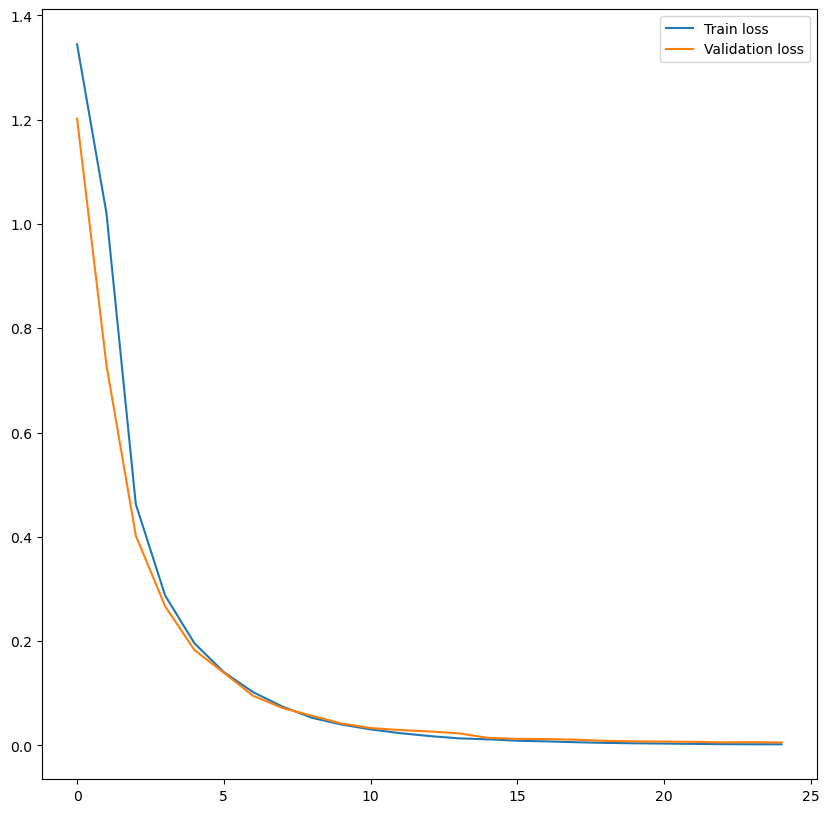

In [85]:
plt.figure(figsize=(10,10))
plt.plot(train_error, label="Train loss")
plt.plot(validation_error, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# Example of target with class indices
# non capisco come funzioni tbh
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print("target tensor:", target)
output = loss(input, target)
output.backward()

# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print("target tensor:", target)
output = loss(input, target)
output.backward()

target tensor: tensor([4, 3, 1])
target tensor: tensor([[0.0808, 0.2741, 0.1219, 0.4518, 0.0714],
        [0.1243, 0.3703, 0.0939, 0.2450, 0.1664],
        [0.2252, 0.1695, 0.1627, 0.2942, 0.1484]])


#### Ratatuja

#### considerazioni
- riguardo al padding per avere la corretta concatenazione: alla fine del Reduction block i vari branch devono essere concatenati, i.e. i layer vengono messi in successione lungo la terza dimensione. Per questo è necessario che abbiano tutti la stessa shape (che è facilmente fissata dal MaxPool). Il fattore determinante per ridurre la dimensione del layer è la stride: a stride n corrisponde una riduzione circa di un fattore n (al momento n=2). Una volta fissate la stride e la dimensione del kernel, per ottenere esattamente la shape desiderata è necessario scegliere accuratamente il padding. Pytorch supporta vari metodi per specificare il padding: "same", "valid" (no padding), int o tupla. Con stride=1 il padding per i vari lati è calcolato automaticamente in modo da ottenere in outout la stessa shape dell'input! Quindi ci è molto utile, però funziona solamente per stride=1. Con tupla si può specificare qual è il padding ma solo nelle due direzioni, i.e. NON SUPPPORTA PADDING ASIMMETRICO. In generale possiamo specificare per i singoli casi qual è il padding necessario, ma ciò non è esauriente. Nel caso in cui abbiamo stride>1, se è necessario padding asimmetrico, dobbiamo aggiungerlo manualmente probabilmente con un metodo di functional ad hoc...

- nel right branch: i layer hanno kernel di dimensione crescente (FOV di dimensione crescente) per classificare features più estese man mano che si va più in profondità. Anche il numero delle feature maps cresce con la profondità.\
L'ultimo layer è quello che dimezza le dimensioni.

- durante il training: 1. calcolare i label predetti per una batch 2. calcolare la loss per una batch 3. effettuare la backpropagation con loss.backward() per ottenere i gradienti della loss rispetto ai prametri della NN 4. ottimizzare i parametri con un ottimizzatore con opt.step(), che usa i gradienti calcolati al punto precedente.

#### domande
- perchè vi sono esattamente 3 layer nel right branch? Cambia significativamente se si modifica il numero?
- come fa l'ottimizzatore a leggere i gradienti?

#### TODO
- eliminare ``cache file" nella
- provare a modificare l'ordine dei layers nell'ultimo branch per vedere se cambia? Forse inutile perchè perdo comprimerei l'informazione prima